# SAMN'S MERCADO: END TO END E-COMMERCE PLATFORM
---
LEARNING TEAM 3 - ASIS, ITUCAL, MERCADO, RIZADA

## Introduction
This project demonstrates the data engineering skills learned in the elective by developing an e-commerce platform that not only enables customers to browse and purchase a diverse selection of goods online but also empowers vendors with an analytics platform built on data lakes and data warehouses. By leveraging these technologies, vendors can track sales performance, gain actionable insights, and enable Data Science, Analytics, and AI (DSAI) capabilities to optimize their business strategies.

## Architecture Overview
### End to end system architecture:
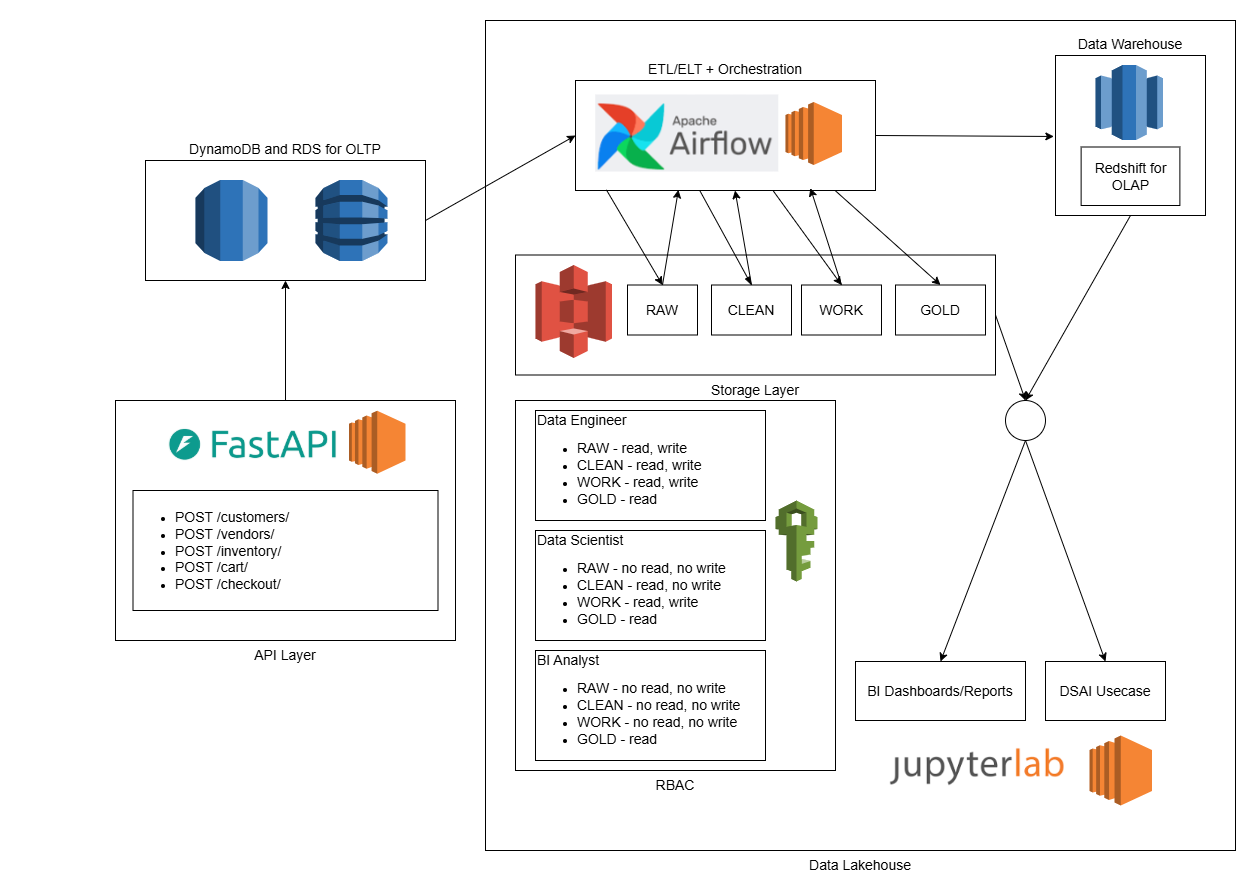

The end to end solution will include:
- API interfaces for data upload 
- OLTP processing (DynamoDB+Postgres)
- Orchestration and ETL/ELT
- Data Lakehouse
- Storage Layers
- RBAC (Role Based Access Control)
- OLTP Data Warehouse
- Consumption

### Docker Architecture:
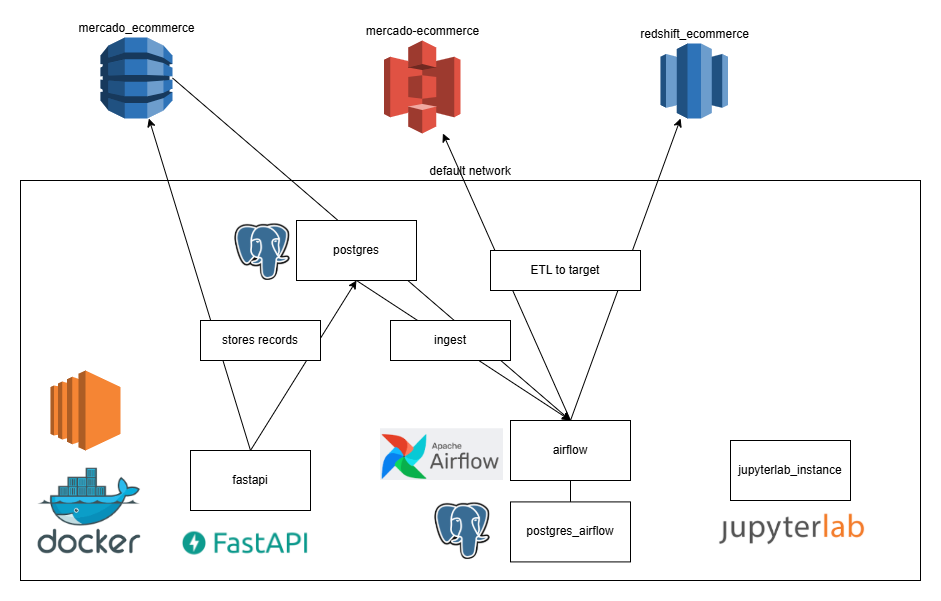

Services are deployed via Docker in the EC2 instance for ease of deployment and easy to spin up and tear down.
- Postgres for OLTP - Instead of using RDS for postgres we will just use a postgres contained inside our docker network
- Airflow + Postgres - Orchestration and workflow
- Jupyterlab container - to run inserts, and provide DSAI use case in consumption.

### Directory Structure
- `src` - source codes
    - `airflow` - airflow source codes
    - `api` - fastapi source codes                           
    - `dockerfiles` - Dockerfile definition for the services
    - `jupyterlab` - Notebooks and Images
    - `sql` - sql references for create tables
- `.github/workflows` - pre-commit hooks via github actions
- `sample_env` - sample env file to be filled up in an actual `.env file`
- `.pre-commit-config.yaml` - pre-commit dependencies
- `docker-compose.yml` - docker compose definitions

## API Layer
In this layer we use the API endpoints served via fastapi to:
- Submit customers
- Submit vendors
- Submit inventory of vendors
- Simulate customer adding to cart, checking out and leaving items in their carts

In [1]:
%load_ext sql

In [2]:
import boto3
import requests
import os
import pandas as pd
from sqlalchemy import create_engine
from faker import Faker
import redshift_connector

In [3]:
pd.set_option('display.max_rows', 12)
pd.set_option('display.min_rows', 6)

We will use faker to submit dummy API requests based on the definitions above.

In [4]:
fake = Faker()

base_url = "http://fastapi:8000"
headers = {"Content-Type": "application/json"}

print("customers")
# Create customers
for customer_id in range(1, 11):
    data = {
        "first_name": fake.first_name(),
        "last_name": fake.last_name(),
        "email": fake.email(),
        "joined_at": fake.iso8601()
    }
    response = requests.post(f"{base_url}/customers/", json=data, headers=headers)
    print(response.status_code, response.json())

print("vendors")
# Create vendors
for vendor_id in range(1, 6):
    data = {
        "vendor_name": fake.company(),
        "region": fake.country_code()
    }
    response = requests.post(f"{base_url}/vendors/", json=data, headers=headers)
    print(response.status_code, response.json())

print("inventory per vendor")
# Add inventory per vendor
for vendor_id in range(1, 6):
    for item_id in range(1, 11):
        params = {"vendor_id": vendor_id}
        data = {
            "item_name": fake.word(),
            "category": str(1),
            "price": fake.random_int(min=10, max=500),
        }
        response = requests.post(f"{base_url}/inventory/", json=data, headers=headers, params=params)
        print(response.status_code, response.json())

print("cart and checkout twice and add to cart again!")
for customer_id in range(1, 11):
    for _ in range(2):  # Checkout twice
        price1 = fake.random_int(min=10, max=500)
        price2 = fake.random_int(min=10, max=500)
        qty1 = fake.random_int(min=10, max=500)
        qty2 = fake.random_int(min=10, max=500)
        cart_data = {
            "user_id": customer_id,
            "cart": [
                {
                    "item_id": str(fake.random_int(min=1, max=10)),
                    "vendor_id": str(fake.random_int(min=1, max=5)),
                    "qty": qty1,
                    "unit_price": price1,
                    "total_price": qty1*price1,
                },
                {
                    "item_id": str(fake.random_int(min=1, max=10)),
                    "vendor_id": str(fake.random_int(min=1, max=5)),
                    "qty": qty2,
                    "unit_price": price2,
                    "total_price": qty2*price2,
                }
            ]
        }
        response = requests.post(f"{base_url}/cart/", json=cart_data, headers=headers)
        print(response.status_code, response.json())
        
        response = requests.post(f"{base_url}/checkout/", json={"user_id": customer_id}, headers=headers)
        print(response.status_code, response.text)

    price1 = fake.random_int(min=10, max=500)
    price2 = fake.random_int(min=10, max=500)
    qty1 = fake.random_int(min=10, max=500)
    qty2 = fake.random_int(min=10, max=500)
    # Add to cart one more time
    cart_data = {
        "user_id": customer_id,
        "cart": [
            {
                "item_id": str(fake.random_int(min=1, max=10)),
                "vendor_id": str(fake.random_int(min=1, max=5)),
                "qty": qty1,
                "unit_price": price1,
                "total_price": qty1*price1,
            },
            {
                "item_id": str(fake.random_int(min=1, max=10)),
                "vendor_id": str(fake.random_int(min=1, max=5)),
                "qty": qty1,
                "unit_price": price1,
                "total_price": qty1*price1,
            }
        ]
    }
    response = requests.post(f"{base_url}/cart/", json=cart_data, headers=headers)
    print(response.status_code, response.json())

customers
201 {'id': 1, 'first_name': 'Darlene', 'last_name': 'Stafford', 'email': 'nmclaughlin@example.net', 'joined_at': '2025-03-16T17:33:41.157140'}
201 {'id': 2, 'first_name': 'Sally', 'last_name': 'Stein', 'email': 'laura63@example.org', 'joined_at': '2025-03-16T17:33:41.168283'}
201 {'id': 3, 'first_name': 'Erik', 'last_name': 'Thompson', 'email': 'lowerobert@example.org', 'joined_at': '2025-03-16T17:33:41.178082'}
201 {'id': 4, 'first_name': 'Sharon', 'last_name': 'Christensen', 'email': 'erikaperry@example.org', 'joined_at': '2025-03-16T17:33:41.186842'}
201 {'id': 5, 'first_name': 'Lee', 'last_name': 'Ayers', 'email': 'xroman@example.net', 'joined_at': '2025-03-16T17:33:41.196611'}
201 {'id': 6, 'first_name': 'Mary', 'last_name': 'Lopez', 'email': 'johnsoncody@example.org', 'joined_at': '2025-03-16T17:33:41.207401'}
201 {'id': 7, 'first_name': 'Tracy', 'last_name': 'Meyer', 'email': 'melissabaxter@example.com', 'joined_at': '2025-03-16T17:33:41.216504'}
201 {'id': 8, 'first_n

In [5]:
OLTP_USER = os.getenv("POSTGRES_USER")
OLTP_PASS = os.getenv("POSTGRES_PASSWORD")
OLTP_HOST = os.getenv("POSTGRES_HOST")
OLTP_DB_NAME = os.getenv("POSTGRES_DB")
OLAP_USER = os.getenv("REDSHIFT_USER")
OLAP_PASS = os.getenv("REDSHIFT_PASSWORD")
OLAP_HOST = os.getenv("REDSHIFT_HOST")
OLAP_DB_NAME = os.getenv("REDSHIFT_DB")

In [6]:
connection_string = f"postgresql://{OLTP_USER}:{OLTP_PASS}@{OLTP_HOST}:5432/{OLTP_DB_NAME}"
engine = create_engine(connection_string)
get_ipython().run_line_magic('sql', connection_string)

Connecting to 'postgresql://user:***@db:5432/ecommerce'

## Viewing OLTP Layer - Postgres and NoSQL Contents
Implementing the OLTP layer both SQL and NoSQL storage was used to handle different use cases:
- Postgres in RDS
    - customer table
    - vendor table
    - inventory table
- NoSQL DynamoDB
    - cart details
    - customer transaction history

### Postgres side

ERD:

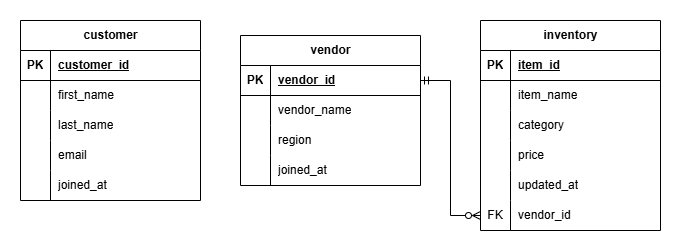

The selected tables were stored in PostgreSQL to take advantage of its SQL-friendly search capabilities. On the customer side, this allows for efficient searching of products by item name or vendor name, enhancing the shopping experience. On the vendor side, PostgreSQL enables seamless lookup of specific clients using their name or email, making it easier to manage customer relationships and track transactions.

In [7]:
%sql \dt

Running query in 'postgresql://user:***@db:5432/ecommerce'

Schema,Name,Type,Owner
public,customer,table,user
public,inventory,table,user
public,vendor,table,user


In [8]:
table_list = [
    "customer", "inventory", "vendor"
]

In [9]:
for table in table_list:
    print(f"{table}")
    schema_query = f"columns --table {table}"
    display(get_ipython().run_line_magic('sqlcmd', schema_query))

customer


name,type,nullable,default,autoincrement,comment
id,INTEGER,False,nextval('customer_id_seq'::regclass),True,None
first_name,TEXT,False,None,False,None
last_name,TEXT,False,None,False,None
email,TEXT,False,None,False,None
joined_at,TIMESTAMP,False,None,False,None


inventory


name,type,nullable,default,autoincrement,comment
id,INTEGER,False,nextval('inventory_id_seq'::regclass),True,None
item_name,TEXT,False,None,False,None
category,TEXT,False,None,False,None
price,INTEGER,False,None,False,None
updated_at,TIMESTAMP,False,None,False,None
vendor_id,INTEGER,True,None,False,None


vendor


name,type,nullable,default,autoincrement,comment
id,INTEGER,False,nextval('vendor_id_seq'::regclass),True,None
vendor_name,TEXT,False,None,False,None
region,TEXT,False,None,False,None
joined_at,TIMESTAMP,False,None,False,None


In [10]:
for table in table_list:
    print(f"{table}")
    display(pd.read_sql(f"select * from {table} limit 100", engine.raw_connection()))

customer


/tmp/ipykernel_32/2234210053.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  display(pd.read_sql(f"select * from {table} limit 100", engine.raw_connection()))


,id,first_name,last_name,email,joined_at
0,1,Darlene,Stafford,nmclaughlin@example.net,2025-03-16 17:33:41.157140
1,2,Sally,Stein,laura63@example.org,2025-03-16 17:33:41.168283
2,3,Erik,Thompson,lowerobert@example.org,2025-03-16 17:33:41.178082
3,4,Sharon,Christensen,erikaperry@example.org,2025-03-16 17:33:41.186842
4,5,Lee,Ayers,xroman@example.net,2025-03-16 17:33:41.196611
5,6,Mary,Lopez,johnsoncody@example.org,2025-03-16 17:33:41.207401
6,7,Tracy,Meyer,melissabaxter@example.com,2025-03-16 17:33:41.216504
7,8,Melissa,Padilla,coffeyrebecca@example.com,2025-03-16 17:33:41.225507
8,9,Traci,Hoffman,orobinson@example.com,2025-03-16 17:33:41.233950
9,10,Laura,Duran,peter17@example.com,2025-03-16 17:33:41.241810


inventory


/tmp/ipykernel_32/2234210053.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  display(pd.read_sql(f"select * from {table} limit 100", engine.raw_connection()))


,id,item_name,category,price,updated_at,vendor_id
0,1,drive,1,70,2025-03-16 17:33:41.300495,1
1,2,week,1,252,2025-03-16 17:33:41.309919,1
2,3,look,1,131,2025-03-16 17:33:41.319892,1
...,...,...,...,...,...,...
47,48,before,1,219,2025-03-16 17:33:41.749126,5
48,49,page,1,51,2025-03-16 17:33:41.759332,5
49,50,yourself,1,242,2025-03-16 17:33:41.769359,5


vendor


/tmp/ipykernel_32/2234210053.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  display(pd.read_sql(f"select * from {table} limit 100", engine.raw_connection()))


,id,vendor_name,region,joined_at
0,1,Jordan PLC,BB,2025-03-16 17:33:41.251048
1,2,"Frank, Meyer and Clark",NG,2025-03-16 17:33:41.261866
2,3,"Lopez, Hayes and Webster",DK,2025-03-16 17:33:41.272243
3,4,"Travis, Mason and Guerrero",NA,2025-03-16 17:33:41.281820
4,5,English Inc,NE,2025-03-16 17:33:41.290086


### DynamoDB side

ERD/Entity Containment in NoSQL:

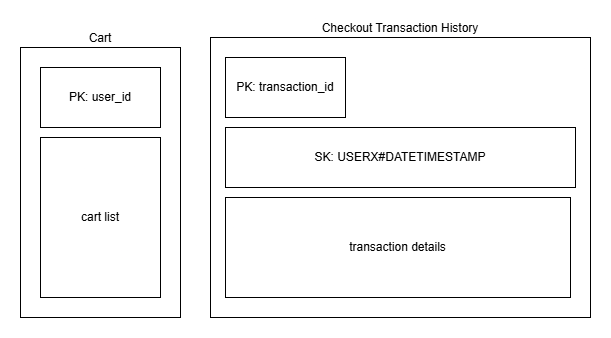

The Cart and Transaction entities are stored in DynamoDB to take advantage of its flexible schema and high-performance read/write capabilities. The Cart table uses `user_id` as the partition key (PK), allowing it to store a nested list of items efficiently, enabling quick updates and retrievals as users modify their carts. The Transaction table is structured with `transaction_id` as the partition key (PK) and `user_id + timestamp` as the sort key (SK), ensuring efficient lookups and chronological ordering of transactions per user. DynamoDB’s scalability and fast access times make it an ideal choice for handling real-time cart updates and transaction history in a dynamic e-commerce environment.

In [13]:
dynamodb = boto3.resource("dynamodb", "us-east-1")
table = dynamodb.Table("mercado_ecommerce")
table.scan()['Items'][:3]

[{'updated_at': '2025-03-16T17:33:42.376194',
  'sk': 'CART',
  'pk': 'USER#8',
  'cart': [{'unit_price': Decimal('265'),
    'total_price': Decimal('12455'),
    'item_id': '5',
    'qty': Decimal('47'),
    'vendor_id': '5'},
   {'unit_price': Decimal('265'),
    'total_price': Decimal('12455'),
    'item_id': '4',
    'qty': Decimal('47'),
    'vendor_id': '1'}]},
 {'sk': 'USER8#2025-03-16T17:33:42.339612',
  'created_at': '2025-03-16T17:33:42.339612',
  'pk': '41c040b7-8532-440b-9b9f-193d4d60bbc9',
  'cart': [{'unit_price': Decimal('412'),
    'total_price': Decimal('191168'),
    'item_id': '5',
    'qty': Decimal('464'),
    'vendor_id': '4'},
   {'unit_price': Decimal('436'),
    'total_price': Decimal('81532'),
    'item_id': '10',
    'qty': Decimal('187'),
    'vendor_id': '1'}]},
 {'updated_at': '2025-03-16T17:33:41.969889',
  'sk': 'CART',
  'pk': 'USER#2',
  'cart': [{'unit_price': Decimal('142'),
    'total_price': Decimal('41180'),
    'item_id': '4',
    'qty': Decimal(

## Worflow, Orchestration and ETL/ELT
Here we will be discussing the workflow deployed in Airflow.

In [ ]:
connection_string = f"postgresql://{OLAP_USER}:{OLAP_PASS}@{OLAP_HOST}:5439/{OLAP_DB_NAME}"
engine = redshift_connector.connect(
    host=OLAP_HOST,
    port=5439,
    database=OLAP_DB_NAME,
    user=OLAP_USER,
    password=OLAP_PASS
)
engine = create_engine(connection_string)
get_ipython().run_line_magic('sql', connection_string)

In [ ]:
%sql \dt

In [ ]:
table_list = [
    "category", "customer", "date", "inventory", "vendor", "sales"
]

In [ ]:
for table in table_list:
    print(f"{table}")
    schema_query = f"columns --table {table}"
    display(get_ipython().run_line_magic('sqlcmd', schema_query))

In [ ]:
for table in table_list:
    print(f"{table}")
    display(pd.read_sql(f"select * from {table} limit 100", engine.raw_connection()))